In [1]:
#since noteboke doesn't work in jupiterlabs    %matplotlib notebook 
%matplotlib notebook
%load_ext autoreload
%autoreload 2

<h1> All code in this repo optimized for my linux computer. change the os.chdir path in all files to be dynamic befre posting code! </h1>

In [2]:
import os
os.chdir('/home/dana_z/ssd_2TB/6OHDA')
#import mpld3
#mpld3.enable_notebook()
import numpy as np
import scipy as sci
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as Mcolors
import matplotlib.cm as cmx
import sys
import h5py
from IO import *
from utils import *
from plotUtils import *
from ColorSchems import colorPallet as CP
import pptx
from pptx import Presentation 
from pptx.util import Inches
from io import BytesIO
import re
import warnings
import pandas as pd
import sqlalchemy as db
import gc
from tqdm import tqdm
import seaborn as sns
import pywt # wavelet package

In [6]:
Files = ['FinalData_6OHDA.h5','FinalData_6OHDA_H.h5','FinalData_6OHDA_H_skip.h5','FinalData_6OHDA_skip.h5']
miceList = getMiceList(Files[0])
# data for Beta Mice - NOTICE: ONLY 1222 is CHI rest are PV
betaMice = ['8430','4539','7584','7909','1222']

In [10]:
# data for all mice - homomorphic filter - Only Amphetamine sessions
HfPVdataH = getData(Files[1],['speed','trace'],period ='Post', cre='PV',red = True,day = lambda x: x==0 )
HfPVdataP = getData(Files[1],['speed','trace'],period ='Post', cre='PV',red = True,day = lambda x: x>0 )
HfMSNdataH = getData(Files[1],['speed','trace'],period ='Post',red = False,day = lambda x: x==0 )
HfMSNdataP = getData(Files[1],['speed','trace'],period ='Post',red = False,day = lambda x: x>0 )
HfCHIdataH = getData(Files[1],['speed','trace'],period ='Post', cre='CHI',red = True,day = lambda x: x==0 )
HfCHIdataP = getData(Files[1],['speed','trace'],period ='Post', cre='CHI',red = True,day = lambda x: x>0 )


cleaning up trace data
I deleted session: 4539_day0
I deleted session: 7584_Baseline0
I deleted session: 7584_day0
I deleted session: 7909_day0
I deleted session: 8430_BaselineA
cleaning up trace data
cleaning up speed data
cleaning up trace data
I deleted session: 1236_day1
I deleted session: 1236_day11
I deleted session: 1236_day13
I deleted session: 1236_day19L
I deleted session: 1236_day3
I deleted session: 1236_day5
I deleted session: 1236_day7
I deleted session: 1236_day9
I deleted session: 4539_day1
I deleted session: 4539_day10
I deleted session: 4539_day11
I deleted session: 4539_day12
I deleted session: 4539_day13
I deleted session: 4539_day14
I deleted session: 4539_day2
I deleted session: 4539_day3
I deleted session: 4539_day4
I deleted session: 4539_day5
I deleted session: 4539_day6
I deleted session: 4539_day7
I deleted session: 4539_day8
I deleted session: 4539_day9
I deleted session: 7584_day1
I deleted session: 7584_day10
I deleted session: 7584_day11
I deleted session

In [3]:
def periodCalc(day):
    if day== 0:
        return 'Healthy'
    elif day<5:
        return 'Day 1-4'
    elif day<13:
        return 'Day 5-12'
    elif day<21:
        return 'Day 13-20'
    else:
        return 'One Month'

Get pre and post firing rates into a df 

In [11]:
#f = h5py.File('OnsetsAndPeriods.hdf5','r')
col_names = ['Mouse','Sess','Day','Period','drugPeriod','start_high',
             'start_med','start_low','All_','end_high','end_med',
             'end_low','acc','dcc']
df = pd.DataFrame(columns = col_names)
cond = ['PVdataH','MSNdataH','CHIdataH','PVdataP','MSNdataP','CHIdataP']
transWindow = np.ones((10,1))
for c in cond:
    data = eval('Hf'+c)
    for sess in data.keys():
#        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])
            m = sess[0:4]
            period = periodCalc(day)
            if sess[-1] == 'A':
                drug = "Amph"
            elif sess[-1] == 'S':
                drug = 'Saline'
            else:
                drug = 'LDopa'
                    
            
            for drugPeriod in ['Pre','Post']:

                Hp = getOnsetOrPeriod(m,sess,drugPeriod,'HighMvmtPeriods_vector')
                Lp = getOnsetOrPeriod(m,sess,drugPeriod,'LowMvmtPeriods_vector')
                Mp = ((Hp+Lp)==0)
                Ca = getOnsetOrPeriod(m,sess,drugPeriod,'caOnset_Hf')
                CaO = Ca[:,1:]-Ca[:,:-1]
                if CaO.shape[1]<Hp.shape[0]:
                     CaO = np.append(CaO,np.zeros((CaO.shape[0],1)),axis=1)
                elif CaO.shape[1]>Hp.shape[0]:
                     CaO = CaO[:,:-1]

                C_start = (CaO==1)*1
                C_end = (CaO==-1)*1
    #            Acc = np.append(np.convolve(np.diff(Lp*1+Mp*2+Hp*3)>0, transWindow[:,0], mode='same')>0,False)
    #            Dcc = np.append(np.convolve(np.diff(Lp*1+Mp*2+Hp*3)<0, transWindow[:,0], mode='same')>0,False)
                Acc = np.append(np.convolve(np.diff(Lp*1+Hp*2)>0, transWindow[:,0], mode='same')>0,False)
                Dcc = np.append(np.convolve(np.diff(Lp*1+Hp*2)<0, transWindow[:,0], mode='same')>0,False)
                a = np.asarray([np.sum(C_start[:,Hp],axis=1),np.sum(C_start[:,Mp],axis=1),
                                np.sum(C_start[:,Lp],axis=1),np.sum(C_start,axis=1),
                                np.sum(C_end[:,Hp],axis=1),np.sum(C_end[:,Mp],axis=1),np.sum(C_end[:,Lp],axis=1),
                                np.sum(C_end[:,Acc],axis=1),np.sum(C_end[:,Dcc],axis=1)]).T
                df2 = pd.DataFrame(a, columns = col_names[5:])
                df2['totalTime'] = (Hp.shape[0]/1200)
                df2['lowTime'] = np.sum(Lp/1200)
                df2['medTime'] = np.sum(Mp/1200)
                df2['highTime'] = np.sum(Hp/1200)
    #            df2['accTrans'] = np.sum(np.diff(Lp*1+Mp*2+Hp*3)>0)
    #            df2['dccTrans'] = np.sum(np.diff(Lp*1+Mp*2+Hp*3)<0)
                df2['accTrans'] = np.sum(np.diff(Lp*1+Hp*2)>0)
                df2['dccTrans'] = np.sum(np.diff(Lp*1+Hp*2)<0)
                df2['Day'] = day
                df2['Mouse'] = m
                df2['Sess'] = sess
                df2['Drug'] = drug
                df2['CellType'] = c[:-5]
                df2['drugPeriod'] = drugPeriod
                df2['Beta'] = (m in betaMice) 
                df2['Period'] = period
                df = pd.concat([df,df2],sort=True)
#        except:
#            print(sess,c,sys.exc_info())



In [15]:
#df[['lowTime','highTime','medTime']].describe()
df.shape

(47896, 23)

In [16]:
df['High'] =  df.apply (lambda row: row.start_high/row.highTime if row.highTime != 0 else row.start_high, axis=1)
df['Medium'] = df.apply (lambda row: row.start_med/row.medTime, axis=1)
df['Low'] = df.apply (lambda row: row.start_low/row.lowTime  if row.lowTime >0 else 0 , axis=1)
df['All'] = df.apply (lambda row: row.All_/row.totalTime , axis=1)
df['Acc'] = df.apply (lambda row: row.acc/row.accTrans , axis=1)
df['Dcc'] = df.apply (lambda row: row.dcc/row.dccTrans , axis=1)
df['Acc_'] = df.apply (lambda row: row.acc/row.All_ if row.All_ >0 else 0 , axis=1)
df['Dcc_'] = df.apply (lambda row: row.dcc/row.All_ if row.All_ >0 else 0 , axis=1)

df.to_csv('D1D2_Analysis')
df.head()

,All_,Beta,CellType,Day,Drug,Mouse,Period,Sess,acc,accTrans,...,start_med,totalTime,High,Medium,Low,All,Acc,Dcc,Acc_,Dcc_
0,1,False,PV,0,Amph,1236,Healthy,1236_BaselineA,1,100.0,...,0,9.915833,0.000000,0.000000,0.147783,0.100849,0.01,0.000000,1.000000,0.000000
1,9,False,PV,0,Amph,1236,Healthy,1236_BaselineA,0,100.0,...,2,9.915833,3.022670,1.337793,0.295567,0.907639,0.00,0.009901,0.000000,0.111111
2,6,False,PV,0,Amph,1236,Healthy,1236_BaselineA,2,100.0,...,5,9.915833,0.604534,3.344482,0.000000,0.605093,0.02,0.009901,0.333333,0.166667
3,13,False,PV,0,Amph,1236,Healthy,1236_BaselineA,2,100.0,...,5,9.915833,3.627204,3.344482,0.295567,1.311035,0.02,0.009901,0.153846,0.076923
4,8,False,PV,0,Amph,1236,Healthy,1236_BaselineA,0,100.0,...,2,9.915833,2.418136,1.337793,0.295567,0.806790,0.00,0.000000,0.000000,0.000000


In [105]:
df = pd.read_csv('D1D2_Analysis.csv')
df.head()

,NeuronNumber,All_,Beta,CellType,Day,Drug,Mouse,Period,Sess,acc,...,start_med,totalTime,High,Medium,Low,All,Acc,Dcc,Acc_,Dcc_
0,0,1,False,PV,0,Amph,1236,Healthy,1236_BaselineA,1,...,0,9.915833,0.000000,0.000000,0.147783,0.100849,0.01,0.000000,1.000000,0.000000
1,1,9,False,PV,0,Amph,1236,Healthy,1236_BaselineA,0,...,2,9.915833,3.022670,1.337793,0.295567,0.907639,0.00,0.009901,0.000000,0.111111
2,2,6,False,PV,0,Amph,1236,Healthy,1236_BaselineA,2,...,5,9.915833,0.604534,3.344482,0.000000,0.605093,0.02,0.009901,0.333333,0.166667
3,3,13,False,PV,0,Amph,1236,Healthy,1236_BaselineA,2,...,5,9.915833,3.627204,3.344482,0.295567,1.311035,0.02,0.009901,0.153846,0.076923
4,4,8,False,PV,0,Amph,1236,Healthy,1236_BaselineA,0,...,2,9.915833,2.418136,1.337793,0.295567,0.806790,0.00,0.000000,0.000000,0.000000


In [106]:
df2 = df[['Sess','NeuronNumber','Beta','Period','Drug','drugPeriod','All']]
df2 = df2.pivot_table(values='All', index=['Sess','Drug','NeuronNumber','Beta','Period'], columns='drugPeriod')
df2.head()

drugPeriod                                          Post       Pre
Sess           Drug NeuronNumber Beta  Period                     
0761_BaselineA Amph 0            False Healthy  0.066670  1.008488
                    1            False Healthy  0.066670  0.504244
                    2            False Healthy  0.033335  0.302546
                    3            False Healthy  0.000000  0.000000
                    4            False Healthy  0.000000  2.117825

In [51]:
for drug in df.Drug.unique():
    print()
    print(drug,':')
    print()
    print('# neurons 0 spikes in both pre and post',df2.query("Drug == '"+drug+"' and Post==0 and Pre ==0").count())
    print('# neurons 0 spikes in pre only',df2.query("Drug == '"+drug+"' and Post!=0 and Pre==0").count())
    print('# neurons 0 spikes in post only',df2.query("Drug == '"+drug+"' and Post==0 and Pre!=0").count())


Amph :

# neurons 0 spikes in both pre and post drugPeriod
Post    868
Pre     868
dtype: int64
# neurons 0 spikes in pre only drugPeriod
Post    502
Pre     502
dtype: int64
# neurons 0 spikes in post only drugPeriod
Post    1892
Pre     1892
dtype: int64

LDopa :

# neurons 0 spikes in both pre and post drugPeriod
Post    624
Pre     624
dtype: int64
# neurons 0 spikes in pre only drugPeriod
Post    513
Pre     513
dtype: int64
# neurons 0 spikes in post only drugPeriod
Post    1021
Pre     1021
dtype: int64

Saline :

# neurons 0 spikes in both pre and post drugPeriod
Post    208
Pre     208
dtype: int64
# neurons 0 spikes in pre only drugPeriod
Post    130
Pre     130
dtype: int64
# neurons 0 spikes in post only drugPeriod
Post    567
Pre     567
dtype: int64


In [64]:
df3 = df2.query("Post>Pre").groupby(["Sess",'Drug','Period']).count()/df2.groupby(["Sess",'Drug','Period']).count()
df3.groupby(["Drug","Period"]).Post.describe()

count      mean       std       min       25%       50%  \
Drug   Period                                                               
Amph   Day 13-20   11.0  0.223046  0.132550  0.020833  0.117703  0.255034   
       Healthy     18.0  0.101766  0.062230  0.011173  0.055401  0.104736   
       One Month   12.0  0.128121  0.138132  0.012579  0.034537  0.097267   
LDopa  Day 13-20   11.0  0.240892  0.052351  0.119403  0.219541  0.250000   
       Healthy     13.0  0.156931  0.107655  0.026667  0.062500  0.171779   
       One Month   11.0  0.158112  0.092650  0.050633  0.086985  0.110092   
Saline Healthy     13.0  0.103015  0.052802  0.027624  0.060606  0.105932   

                       75%       max  
Drug   Period                         
Amph   Day 13-20  0.336028  0.436364  
       Healthy    0.151327  0.235294  
       One Month  0.135081  0.456522  
LDopa  Day 13-20  0.270931  0.312500  
       Healthy    0.226277  0.388430  
       One Month  0.239754  0.317829  
Saline Healthy    0.153846  0.179775

In [67]:
# only look at first 10min (15min?) after drug infusion.
f = h5py.File('OnsetsAndPeriods.hdf5','r')
col_names = ['Mouse','Sess','Day','Period','drugPeriod','start_high',
             'start_med','start_low','All_','end_high','end_med',
             'end_low','acc','dcc']
df = pd.DataFrame(columns = col_names)
cond = ['PVdataH','MSNdataH','CHIdataH','PVdataP','MSNdataP','CHIdataP']
transWindow = np.ones((10,1))
for c in cond:
    data = eval('Hf'+c)
    for sess in data.keys():
#        try:
            if sess[5] == 'B':
                day = 0
            else:
                day = int(re.findall(r'\d+',sess[5:])[0])
            m = sess[0:4]
            period = periodCalc(day)
            if sess[-1] == 'A':
                drug = "Amph"
            elif sess[-1] == 'S':
                drug = 'Saline'
            else:
                drug = 'LDopa'

            
            for drugPeriod in ['Pre','Post']:
                
                Hp = getOnsetOrPeriod(m,sess,drugPeriod,'HighMvmtPeriods_vector')
                Lp = getOnsetOrPeriod(m,sess,drugPeriod,'LowMvmtPeriods_vector')
                Mp = ((Hp+Lp)==0)
                Ca = getOnsetOrPeriod(m,sess,drugPeriod,'caOnset_Hf')
                CaO = Ca[:,1:]-Ca[:,:-1]
                if CaO.shape[1]<Hp.shape[0]:
                     CaO = np.append(CaO,np.zeros((CaO.shape[0],1)),axis=1)
                elif CaO.shape[1]>Hp.shape[0]:
                     CaO = CaO[:,:-1]
                
                # if post shorten the vectors:
                if drugPeriod == 'Post':
                    Fs = data[sess]['trace']['FS'][0]
                    t = int(900*Fs) #15min * sampling rate
                    Hp = Hp[:t]
                    Lp = Lp[:t]
                    Mp = Mp[:t]
                    CaO = CaO[:,:t]

    
                C_start = (CaO==1)*1
                C_end = (CaO==-1)*1
                Acc = np.append(np.convolve(np.diff(Lp*1+Hp*2)>0, transWindow[:,0], mode='same')>0,False)
                Dcc = np.append(np.convolve(np.diff(Lp*1+Hp*2)<0, transWindow[:,0], mode='same')>0,False)
                a = np.asarray([np.sum(C_start[:,Hp],axis=1),np.sum(C_start[:,Mp],axis=1),
                                np.sum(C_start[:,Lp],axis=1),np.sum(C_start,axis=1),
                                np.sum(C_end[:,Hp],axis=1),np.sum(C_end[:,Mp],axis=1),np.sum(C_end[:,Lp],axis=1),
                                np.sum(C_end[:,Acc],axis=1),np.sum(C_end[:,Dcc],axis=1)]).T
                df2 = pd.DataFrame(a, columns = col_names[5:])
                df2['totalTime'] = (Hp.shape[0]/1200)
                df2['lowTime'] = np.sum(Lp/1200)
                df2['medTime'] = np.sum(Mp/1200)
                df2['highTime'] = np.sum(Hp/1200)
                df2['accTrans'] = np.sum(np.diff(Lp*1+Hp*2)>0)
                df2['dccTrans'] = np.sum(np.diff(Lp*1+Hp*2)<0)
                df2['Day'] = day
                df2['Drug'] = drug
                df2['Mouse'] = m
                df2['Sess'] = sess
                df2['CellType'] = c[:-5]
                df2['drugPeriod'] = drugPeriod
                df2['Beta'] = (m in betaMice) 
                df2['Period'] = period
                df = pd.concat([df,df2],sort=True)
#        except:
#            print(sess,c,sys.exc_info())

df['High'] =  df.apply (lambda row: row.start_high/row.highTime if row.highTime != 0 else row.start_high, axis=1)
df['Medium'] = df.apply (lambda row: row.start_med/row.medTime, axis=1)
df['Low'] = df.apply (lambda row: row.start_low/row.lowTime  if row.lowTime >0 else 0 , axis=1)
df['All'] = df.apply (lambda row: row.All_/row.totalTime , axis=1)
df['Acc'] = df.apply (lambda row: row.acc/row.accTrans , axis=1)
df['Dcc'] = df.apply (lambda row: row.dcc/row.dccTrans , axis=1)
df['Acc_'] = df.apply (lambda row: row.acc/row.All_ if row.All_ >0 else 0 , axis=1)
df['Dcc_'] = df.apply (lambda row: row.dcc/row.All_ if row.All_ >0 else 0 , axis=1)

df.to_csv('D1D2_Analysis_short')
df.head()

/home/dana_z/ssd_2TB/6OHDA/IO.py:563: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return hf[m][s][period][OPtype].value


,All_,Beta,CellType,Day,Drug,Mouse,Period,Sess,acc,accTrans,...,start_med,totalTime,High,Medium,Low,All,Acc,Dcc,Acc_,Dcc_
0,1,False,PV,0,Amph,1236,Healthy,1236_BaselineA,1,100.0,...,0,9.915833,0.000000,0.000000,0.147783,0.100849,0.01,0.000000,1.000000,0.000000
1,9,False,PV,0,Amph,1236,Healthy,1236_BaselineA,0,100.0,...,2,9.915833,3.022670,1.337793,0.295567,0.907639,0.00,0.009901,0.000000,0.111111
2,6,False,PV,0,Amph,1236,Healthy,1236_BaselineA,2,100.0,...,5,9.915833,0.604534,3.344482,0.000000,0.605093,0.02,0.009901,0.333333,0.166667
3,13,False,PV,0,Amph,1236,Healthy,1236_BaselineA,2,100.0,...,5,9.915833,3.627204,3.344482,0.295567,1.311035,0.02,0.009901,0.153846,0.076923
4,8,False,PV,0,Amph,1236,Healthy,1236_BaselineA,0,100.0,...,2,9.915833,2.418136,1.337793,0.295567,0.806790,0.00,0.000000,0.000000,0.000000


In [69]:
df = pd.read_csv('D1D2_Analysis_short.csv')
df.head()

,NeuronNumber,All_,Beta,CellType,Day,Drug,Mouse,Period,Sess,acc,...,start_med,totalTime,High,Medium,Low,All,Acc,Dcc,Acc_,Dcc_
0,0,1,False,PV,0,Amph,1236,Healthy,1236_BaselineA,1,...,0,9.915833,0.000000,0.000000,0.147783,0.100849,0.01,0.000000,1.000000,0.000000
1,1,9,False,PV,0,Amph,1236,Healthy,1236_BaselineA,0,...,2,9.915833,3.022670,1.337793,0.295567,0.907639,0.00,0.009901,0.000000,0.111111
2,2,6,False,PV,0,Amph,1236,Healthy,1236_BaselineA,2,...,5,9.915833,0.604534,3.344482,0.000000,0.605093,0.02,0.009901,0.333333,0.166667
3,3,13,False,PV,0,Amph,1236,Healthy,1236_BaselineA,2,...,5,9.915833,3.627204,3.344482,0.295567,1.311035,0.02,0.009901,0.153846,0.076923
4,4,8,False,PV,0,Amph,1236,Healthy,1236_BaselineA,0,...,2,9.915833,2.418136,1.337793,0.295567,0.806790,0.00,0.000000,0.000000,0.000000


In [70]:
df2 = df[['Sess','NeuronNumber','Beta','Period','Drug','drugPeriod','All']]
df2 = df2.pivot_table(values='All', index=['Sess','Drug','NeuronNumber','Beta','Period'], columns='drugPeriod')
df2.head()

drugPeriod                                          Post       Pre
Sess           Drug NeuronNumber Beta  Period                     
0761_BaselineA Amph 0            False Healthy  0.133333  1.008488
                    1            False Healthy  0.133333  0.504244
                    2            False Healthy  0.066667  0.302546
                    3            False Healthy  0.000000  0.000000
                    4            False Healthy  0.000000  2.117825

In [71]:
for drug in df.Drug.unique():
    print()
    print(drug,':')
    print()
    print('# neurons 0 spikes in both pre and post',df2.query("Drug == '"+drug+"' and Post==0 and Pre ==0").count())
    print('# neurons 0 spikes in pre only',df2.query("Drug == '"+drug+"' and Post!=0 and Pre==0").count())
    print('# neurons 0 spikes in post only',df2.query("Drug == '"+drug+"' and Post==0 and Pre!=0").count())


Amph :

# neurons 0 spikes in both pre and post drugPeriod
Post    1020
Pre     1020
dtype: int64
# neurons 0 spikes in pre only drugPeriod
Post    350
Pre     350
dtype: int64
# neurons 0 spikes in post only drugPeriod
Post    2101
Pre     2101
dtype: int64

LDopa :

# neurons 0 spikes in both pre and post drugPeriod
Post    704
Pre     704
dtype: int64
# neurons 0 spikes in pre only drugPeriod
Post    433
Pre     433
dtype: int64
# neurons 0 spikes in post only drugPeriod
Post    1147
Pre     1147
dtype: int64

Saline :

# neurons 0 spikes in both pre and post drugPeriod
Post    225
Pre     225
dtype: int64
# neurons 0 spikes in pre only drugPeriod
Post    113
Pre     113
dtype: int64
# neurons 0 spikes in post only drugPeriod
Post    609
Pre     609
dtype: int64


In [72]:
df3 = df2.query("Post>Pre").groupby(["Sess",'Drug','Period']).count()/df2.groupby(["Sess",'Drug','Period']).count()
df3.groupby(["Drug","Period"]).Post.describe()

count      mean       std       min       25%       50%  \
Drug   Period                                                               
Amph   Day 13-20   10.0  0.142042  0.069625  0.027778  0.101839  0.133086   
       Healthy     18.0  0.110989  0.053981  0.014354  0.099732  0.116259   
       One Month   12.0  0.153787  0.132013  0.015038  0.049976  0.118485   
LDopa  Day 13-20   11.0  0.273401  0.075648  0.119403  0.223677  0.291667   
       Healthy     13.0  0.171632  0.097022  0.057778  0.081395  0.197080   
       One Month   11.0  0.161368  0.079021  0.058824  0.103468  0.145078   
Saline Healthy     13.0  0.116356  0.043826  0.056657  0.093923  0.105932   

                       75%       max  
Drug   Period                         
Amph   Day 13-20  0.182562  0.250000  
       Healthy    0.126324  0.235294  
       One Month  0.223987  0.456522  
LDopa  Day 13-20  0.330571  0.357143  
       Healthy    0.236196  0.330579  
       One Month  0.228354  0.276486  
Saline Healthy    0.158470  0.185393

In [107]:
df3 = df2.query("Drug=='Saline' and (Post != 0 or Pre !=0)")
df3['ratio'] = df3.apply(lambda row: row.Post/row.Pre if row.Pre !=0 else 1000,axis=1)
df3.head(20)

/home/dana_z/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


drugPeriod                                            Post       Pre  \
Sess           Drug   NeuronNumber Beta  Period                        
0761_BaselineS Saline 0            False Healthy  0.071320  0.705942   
                      1            False Healthy  0.178301  3.328011   
                      2            False Healthy  0.000000  1.109337   
                      4            False Healthy  0.071320  0.000000   
                      5            False Healthy  0.106980  0.000000   
                      6            False Healthy  0.071320  1.109337   
                      7            False Healthy  0.000000  0.100849   
                      8            False Healthy  0.000000  1.512732   
                      9            False Healthy  0.000000  0.100849   
                      10           False Healthy  0.000000  0.100849   
                      11           False Healthy  0.000000  0.705942   
                      12           False Healthy  0.000000  1.210186   
                      13           False Healthy  0.000000  0.403395   
                      14           False Healthy  0.000000  1.008488   
                      15           False Healthy  0.000000  0.100849   
                      16           False Healthy  0.035660  0.100849   
                      17           False Healthy  0.035660  0.504244   
                      18           False Healthy  0.000000  1.109337   
                      19           False Healthy  0.000000  0.504244   
                      20           False Healthy  0.035660  0.100849   

drugPeriod                                              ratio  
Sess           Drug   NeuronNumber Beta  Period                
0761_BaselineS Saline 0            False Healthy     0.101029  
                      1            False Healthy     0.053576  
                      2            False Healthy     0.000000  
                      4            False Healthy  1000.000000  
                      5            False Healthy  1000.000000  
                      6            False Healthy     0.064291  
                      7            False Healthy     0.000000  
                      8            False Healthy     0.000000  
                      9            False Healthy     0.000000  
                      10           False Healthy     0.000000  
                      11           False Healthy     0.000000  
                      12           False Healthy     0.000000  
                      13           False Healthy     0.000000  
                      14           False Healthy     0.000000  
                      15           False Healthy     0.000000  
                      16           False Healthy     0.353600  
                      17           False Healthy     0.070720  
                      18           False Healthy     0.000000  
                      19           False Healthy     0.000000  
                      20           False Healthy     0.353600

<IPython.core.display.Javascript object>


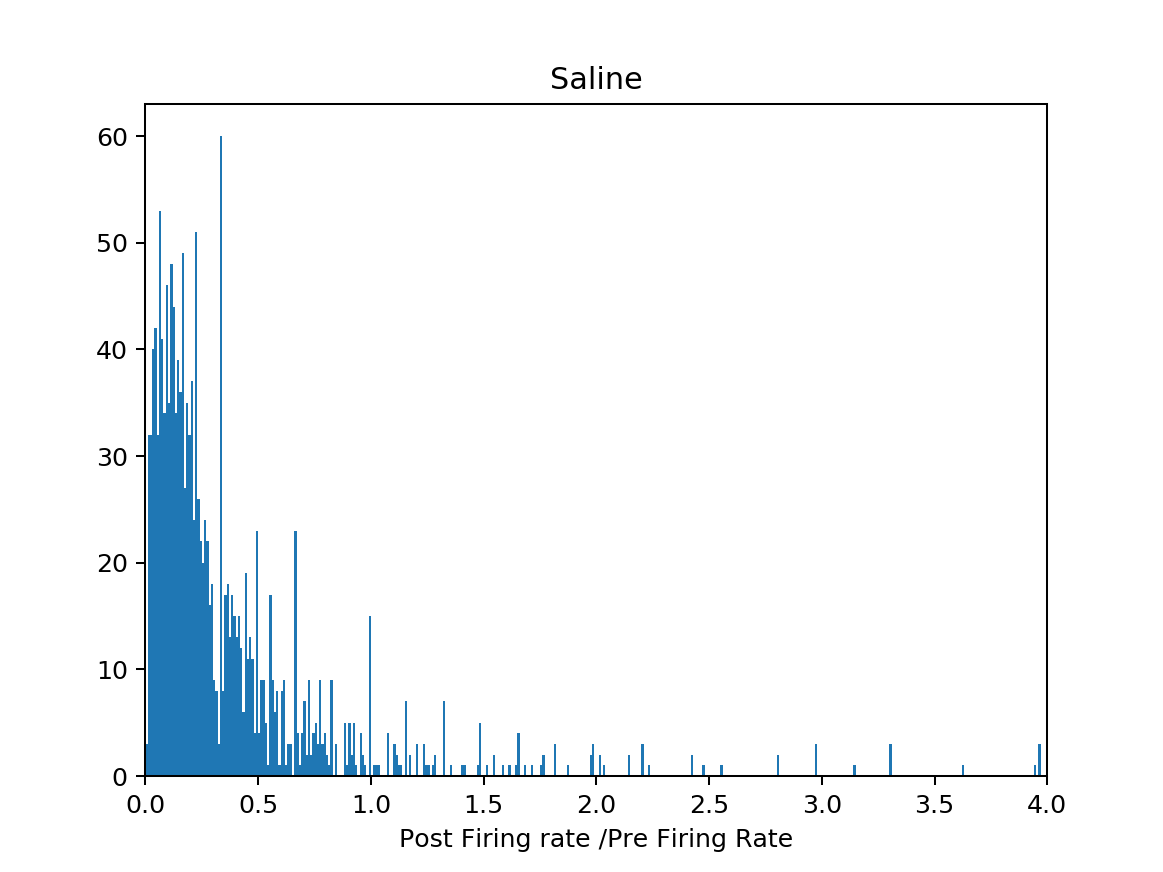

Text(0.5, 1.0, 'Saline')

In [108]:
plt.hist(df3.ratio[(df3.ratio != 1000)& (df3.ratio != 0)],bins=np.arange(0,2000)*0.01)
plt.xlim(0,4)
plt.xlabel('Post Firing rate /Pre Firing Rate')
plt.title('Saline')

In [93]:
np.arange(0,2000)*0.01

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 1.997e+01, 1.998e+01,
       1.999e+01])